# Imports and Functions definitions

In [1]:
import ipywidgets as widgets

In [2]:
import os
import sys
import warnings

from collections import Counter

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from PIL import Image

from scipy import interpolate, optimize, stats
from scipy.fftpack import fft
from scipy.interpolate import interp1d
import scipy.io as sio
from scipy.ndimage import uniform_filter, uniform_filter1d, zoom
from scipy.signal import butter, filtfilt

from sklearn.linear_model import LinearRegression
from skimage.transform import resize

import cv2
from matplotlib.colors import PowerNorm
from scipy.stats import pearsonr

import mat73

pd.set_option('display.max_columns', 50)

# device = "cuda"
random_seed = 42

In [3]:
# define a function to interpolate data
def interpolate_data(Itot, Ttot, tint):
    # get the shape of the input arrays
    z_size, x_size, y_size, t_size = Itot.shape
    # create an empty array for the output
    Iint = np.zeros((z_size, x_size, y_size, len(tint)))
    # loop over the dimensions
    for z in range(z_size):
        for x in range(x_size):
            for y in range(y_size):
                # squeeze the arrays to remove singleton dimensions
                Ttot_squeezed = np.squeeze(Ttot)
                Itot_squeezed = np.squeeze(Itot[z, x, y, :])
                # create an interpolation function using spline method
                interp_func = interp1d(Ttot_squeezed, Itot_squeezed, 
                                       kind='slinear', fill_value='extrapolate' )
                # interpolate the data at the desired time points
                Iint[z, x, y, :] = interp_func(tint)
    # return the output array
    return Iint

def get_clipped_data(I_registered, time):
    # cut data
    timag = np.mean(np.diff(time))
    nz, nx, ny, nt = I_registered.shape
    nstimuli = 8
    ntrials = 8
    tblock = 24
    extra = 36 * 2  # at beginning and very end
    desired_Nimag = round(((nstimuli * tblock) * ntrials + extra) / timag)
    I_cut = I_registered[:, :, :, :desired_Nimag]
    time_cut = time[:desired_Nimag]
    
    
    # interpolation
    dt = 0.5
    timaged = nstimuli * tblock * ntrials + extra
    tint = np.arange(dt, timaged, dt)  # vector for time interpolation

    I_interp = interpolate_data(I_cut, time_cut, tint)
    # correct first image missing if necessary
    if np.isnan(I_interp[:, :, :, 0]).any():
        I_interp[:, :, :, 0] = I_interp[:, :, :, 1]
        
    I_interp2 = I_interp.copy()
    I_interp2 = I_interp2[:,:,:,81:-62]
    return I_interp2

In [4]:


def linear_detrend(data):
    # Initialize an array to hold the detrended data
    detrended_data = np.empty_like(data)

    # Prepare the time variable for linear regression
    time = np.arange(data.shape[3]).reshape(-1, 1)

    # Create a Linear Regression model
    model = LinearRegression()

    # Loop over the first three dimensions
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(data.shape[2]):
                # Fit the model to the time series data
                model.fit(time, data[i, j, k, :])

                # Predict the trend
                trend = model.predict(time)

                # Subtract the trend from the original signal
                detrended_data[i, j, k, :] = data[i, j, k, :] - trend

    return detrended_data

def moving_average_detrend(data, window_size):
    # Create an array of ones for convolution operation
    conv_filter = np.ones(window_size) / window_size

    # Initialize an array to hold the detrended data
    detrended_data = np.empty_like(data)

    # Loop over the first three dimensions
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(data.shape[2]):
                # Apply moving average filter along the time dimension
                smoothed = np.convolve(data[i, j, k, :], conv_filter, mode='same')

                # Subtract the smoothed curve from the original signal
                detrended_data[i, j, k, :] = data[i, j, k, :] - smoothed

    return detrended_data

In [5]:
def get_stacked_slices(data, apply_filter=False, kernel=None, divide_by=3):
    if len(data.shape)>2:
        I_proc = np.zeros((data.shape[0],data.shape[1]*data.shape[2]))
        for j in range(data.shape[2]):
            I_proc[:, j*data.shape[1]:(j+1)*data.shape[1]] = data[:,:,j]
            if apply_filter:
                I_proc[:, j*data.shape[1]:(j+1)*data.shape[1]] = cv.filter2D(data[:,:,j],-1,kernel)
    else:
        I_proc = data

    I_proc = I_proc[:, :]
    crop_len = int(I_proc.shape[1]/divide_by)
    arrays = [I_proc[:,i*crop_len:(i+1)*crop_len] for i in range(divide_by)]
    I_proc=np.vstack(arrays)
    return I_proc

In [6]:
def plot_drift(data, window_size=5, title="test"):
    # Create an array for the x-axis (time steps)
    time_steps = np.arange(data.shape[0])

    # Calculate the moving average
    moving_avg = np.convolve(data, np.ones(window_size), 'valid') / window_size

    fig, ax = plt.subplots(figsize = (40,5))
    # Create the plot for original data
    plt.plot(time_steps, data, label='Original Data')

    # Create the plot for moving average
    plt.plot(time_steps[window_size-1:], moving_avg, label='Moving Average')

    # Optionally, add labels and title
    plt.xlabel('Time steps')
    plt.ylabel('Data')
    plt.title(title)

    # Add legend
    plt.legend()
    plt.savefig(title + '.png')

    # Display the plot
    plt.show()

In [7]:
def save_metadata(dir_name):
    if not os.path.exists(dir_name + '/metadata'):
        os.makedirs(dir_name + '/metadata')
    stimulus_anesth[['stimArray', 'img_id', 'stim_id', 'stim_type']
                   ].to_csv(dir_name+'/metadata/img_ids.csv', index=False)

- The data is from a brain imaging experiment, where the activity of neurons in different regions of the brain is measured over time.
- The data has been aligned to a standard reference brain atlas, which is a map of the brain structures and their locations. The reference atlas used is the Allen Brain Atlas¹, which is a collection of multimodal datasets and tools for studying the brain.
- The data has been interpolated to 2Hz, which means that the sampling rate of the data has been increased by filling in the missing values between the original samples. This can improve the temporal resolution and smoothness of the data.
- The data has been made relative to the mean of the baseline, which means that the average activity level of each region before the experiment started has been subtracted from the data. This can reduce the effects of noise and variability in the data and highlight the changes in activity due to the experiment.
- The data has been motion corrected, which means that any movement of the brain or the imaging device during the experiment has been compensated for. This can improve the spatial accuracy and quality of the data.
- The data has been filtered to remove slow drifts, which are gradual changes in the signal over time that are not related to the experiment. This can enhance the contrast and clarity of the data and reduce artifacts.
- The data has been slightly smoothed temporally, which means that a moving average filter has been applied to the data over time. This can reduce noise and fluctuations in the data and make it easier to see patterns and trends.
- Due to the registration to the reference atlas, which was done at a lower resolution than the original data, the shape of the data has changed slightly. This means that some details or features of the data may have been lost or distorted during the alignment process.

In [8]:
output_path = "/user/l.mysurukrishnamur/data/unprocessed_data"
input_path = "/user/l.mysurukrishnamur/data"
dt_codes=['220423', '220424', '220425', '220426', '220427', '220428', '220429', '220430']

onset = 4
threshold = 98
epsilon = 1e-8 
sub_slice = 66

brain_map_shape = (40, 57, sub_slice)

In [9]:
dt_code = dt_codes[0]

# Info About the stimulus, responses and their shapes 
The stimulus consists of 64 blocks, each block consists of 6s gray screen, 
then 12s image presentations (12 images, 0.5s ON, 0.5s OFF), then 6s gray again. 
So, each block is 24s long. In each block “similar” images were shown, for example 12 birds, 
12 mice etc… I will send you the excel file that has the information on the order of images.

Expected frames: 64*(6+12+6)= 1536 (However, there are double the frames in the reponse. i.e., 3072)

# Clipping and mapping with stimulus

In [10]:
### here the reponse time is sectioned into different blocks based 
### on the experiment paradigm, 
### the indexes are returned for the valid response

def get_sim_to_response_mapping_indices(response):
    stim_array = np.zeros(shape = response.shape[-1])
    row_count = 0
    for start_index in range(12, response.shape[-1], 48):
        for end_index in range(start_index, start_index+24, 2):
            stim_array[end_index] = row_count+1
            row_count+=1
    return stim_array

In [11]:
def corr(on_off_stim, stim):
    # Calculate correlation for each voxel
    correlations = []
    non_nan_correlations = []

    for i in range(on_off_stim.shape[0]):
        correlation_matrix = np.corrcoef(stim[i, :], on_off_stim[i, :])
        correlation = np.diag(correlation_matrix, 1)[0]
        if np.isnan(correlation).any():
            correlations.append(0.0001)
            #correlations.append(correlation)
            #pass
        else:
            correlations.append(correlation)
            non_nan_correlations.append(correlation)

    correlations = np.array(correlations)
    non_nan_correlations = np.array(non_nan_correlations)

    # Calculate average correlation and standard error
    average_correlation = np.mean(non_nan_correlations)
    standard_error = stats.sem(non_nan_correlations)


    print(f"Average Correlation: {average_correlation} ± {standard_error}")
    # print(f"Average Absolute Correlation: {abs_average_correlation} ± {abs_standard_error}")
    return correlations, non_nan_correlations

Assuming there are some invalid entries in th CSV files, I am removing all the entries which doesn't have a stimFile entry. We should get total of 64x12=768 rows since each block has 12 images.

In [12]:
def save_npy_reponses(row, responses, dir_name): 
    if not os.path.exists(dir_name + '/responses'):
        os.makedirs(dir_name + '/responses')
    if not os.path.exists(dir_name + '/images'):
        os.makedirs(dir_name + '/images')
    index=row['index']
    im_array=np.load(row['stimArray'])
    im_array_resized = resize(im_array.squeeze(), (64, 64))
    with open(dir_name + '/responses/'+str(index) +'.npy', 'wb') as f_res:
        np.save(f_res, responses[:,:,:,index])
    with open(dir_name + '/images/'+str(index) +'.npy', 'wb') as f_img:
        np.save(f_img, im_array_resized)
        
    

In [13]:

current_output_path = output_path + '/response_onset_' + str(onset) + '/' + dt_code
print("Running preprocessin for "+dt_code)
print("Current output path "+ current_output_path )
anes_registered = mat73.loadmat(
    input_path + '/DS_WT76_'+dt_code+'_registered.mat')['I_registered']
print("Read data of "+ dt_code)
# This section in converted from matlab to python from the code shared by Dominique
anes_time = mat73.loadmat(
    input_path + '/anes.mat')['time']
clipped_registered_anesth = get_clipped_data(anes_registered, anes_time)

Running preprocessin for 220423
Current output path /user/l.mysurukrishnamur/data/unprocessed_data/response_onset_4/220423
Read data of 220423


In [14]:
stim_to_response_marks = get_sim_to_response_mapping_indices(clipped_registered_anesth)
response_anesth_indices = np.where(stim_to_response_marks>0)
valid_response = clipped_registered_anesth[:,:,:, response_anesth_indices[0]+onset]

stimulus_anesth = pd.read_csv(input_path + "/" +dt_code+".csv")
stimulus_anesth = stimulus_anesth[
    stimulus_anesth.stimFile.notna()].reset_index(drop=True)#.sort_values('image.started')

stimulus_anesth['stim_type'] = stimulus_anesth.stimFile.str.split('/').apply(lambda x:x[1])
stimulus_anesth['stimArray'] = stimulus_anesth.stimFile.apply(
    lambda x: '../data/kaggle/working/' + '/stims/' +x.split('/')[-1].split('.')[0] +'.npy')
stimulus_anesth['img_id'] = stimulus_anesth.groupby(
    'stimFile', as_index=False).ngroup()
stimulus_anesth['stim_id'] = stimulus_anesth.index


In [15]:
stimulus_anesth

,condsFile,stimFile,trials_2.thisRepN,trials_2.thisTrialN,trials_2.thisN,trials_2.thisIndex,blocks.thisRepN,blocks.thisTrialN,blocks.thisN,blocks.thisIndex,trials.thisRepN,trials.thisTrialN,trials.thisN,trials.thisIndex,key_resp.keys,key_resp.rt,key_resp.started,key_resp.stopped,polygon_2.started,polygon_2.stopped,polygon.started,polygon.stopped,image.started,image.stopped,polygon_3.started,polygon_3.stopped,session,participant,date,expName,psychopyVersion,frameRate,Unnamed: 32,stim_type,stimArray,img_id,stim_id
0,MiceBlock.csv,stims/Mice/Mouse9.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,11.0,NaN,NaN,NaN,NaN,23.168175,NaN,57.619404,NaN,70.147808,NaN,70.147808,NaN,1.0,76.0,2022_Apr_23_1538,blockedTrials,2020.1.3,60.336048,NaN,Mice,../data/kaggle/working//stims/Mouse9.npy,35,0
1,MiceBlock.csv,stims/Mice/Mouse7.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,1.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.120917,NaN,71.120917,NaN,1.0,76.0,2022_Apr_23_1538,blockedTrials,2020.1.3,60.336048,NaN,Mice,../data/kaggle/working//stims/Mouse7.npy,33,1
2,MiceBlock.csv,stims/Mice/Mouse8.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,2.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.104237,NaN,72.104237,NaN,1.0,76.0,2022_Apr_23_1538,blockedTrials,2020.1.3,60.336048,NaN,Mice,../data/kaggle/working//stims/Mouse8.npy,34,2
3,MiceBlock.csv,stims/Mice/Mouse11.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.120840,NaN,73.120840,NaN,1.0,76.0,2022_Apr_23_1538,blockedTrials,2020.1.3,60.336048,NaN,Mice,../data/kaggle/working//stims/Mouse11.npy,26,3
4,MiceBlock.csv,stims/Mice/Mouse6.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,4.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.104342,NaN,74.104342,NaN,1.0,76.0,2022_Apr_23_1538,blockedTrials,2020.1.3,60.336048,NaN,Mice,../data/kaggle/working//stims/Mouse6.npy,32,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,Birds_textureBlock.csv,stims/Birds_texture/textureScramble_Bird2.png,7.0,0.0,7.0,0.0,0.0,7.0,7.0,7.0,0.0,7.0,7.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1589.097909,NaN,1589.097909,NaN,1.0,76.0,2022_Apr_23_1538,blockedTrials,2020.1.3,60.336048,NaN,Birds_texture,../data/kaggle/working//stims/textureScramble_...,16,763
764,Birds_textureBlock.csv,stims/Birds_texture/textureScramble_Bird5.png,7.0,0.0,7.0,0.0,0.0,7.0,7.0,7.0,0.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1590.097731,NaN,1590.097731,NaN,1.0,76.0,2022_Apr_23_1538,blockedTrials,2020.1.3,60.336048,NaN,Birds_texture,../data/kaggle/working//stims/textureScramble_...,19,764
765,Birds_textureBlock.csv,stims/Birds_texture/textureScramble_Bird7.png,7.0,0.0,7.0,0.0,0.0,7.0,7.0,7.0,0.0,9.0,9.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1591.099236,NaN,1591.099236,NaN,1.0,76.0,2022_Apr_23_1538,blockedTrials,2020.1.3,60.336048,NaN,Birds_texture,../data/kaggle/working//stims/textureScramble_...,21,765
766,Birds_textureBlock.csv,stims/Birds_texture/textureScramble_Bird12.png,7.0,0.0,7.0,0.0,0.0,7.0,7.0,7.0,0.0,10.0,10.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1592.097190,NaN,1592.097190,NaN,1.0,76.0,2022_Apr_23_1538,blockedTrials,2020.1.3,60.336048,NaN,Birds_texture,../data/kaggle/working//stims/textureScramble_...,15,766


In [16]:
def save_metadata(stimulus_anesth, dir_name, columns= ['stimArray', 'img_id', 'stim_id', 'stim_type']):
    if not os.path.exists(dir_name + '/metadata'):
        os.makedirs(dir_name + '/metadata')
    stimulus_anesth[columns].to_csv(dir_name+'/metadata/img_ids.csv', index=False)

In [17]:

stimulus_anesth.reset_index().apply(
    lambda x: save_npy_reponses(x, valid_response, output_path), axis=1)

save_metadata(current_output_path)

on_off_data = -np.ones_like(clipped_registered_anesth)
on_off_data[:,:,:, np.sort(response_anesth_indices[0]+onset)] = 1.0

shape_stim = on_off_data.shape[-1]
on_off_stim = on_off_data.reshape(40*57*sub_slice, shape_stim)
stim = clipped_registered_anesth.reshape(40*57*sub_slice, shape_stim)
on_off_stim.shape, stim.shape


FileNotFoundError: [Errno 2] No such file or directory: '../data/kaggle/working//stims/Mouse9.npy'

In [ ]:
correlations, non_nan_correlations = corr(on_off_stim, stim)

brain_map_shape = (40, 57, sub_slice)
corr_data_3d = correlations.reshape(brain_map_shape).astype(float)

kernel = np.ones((1,2),np.float32)
corr_slices = get_stacked_slices(corr_data_3d, False, kernel)

thresholded_corr = np.where(corr_data_3d>np.percentile(corr_data_3d.flatten(), threshold, axis=0),
                            corr_data_3d, 0)
thresholded_corr_slices = get_stacked_slices(thresholded_corr)
# Save the indices to a file
np.save(current_output_path+f'/active_indices_percentile_{threshold}.npy', thresholded_corr_indices)
print("Finished processing "+ dt_code)

Average Correlation: 0.002248200429140975 ± 6.580771431660466e-05


NameError: name 'thresholded_corr_indices' is not defined

# ON-OFF correlation for active voxels selection

In [ ]:
def get_stacked_slices(data, apply_filter=False, kernel=None):
    I_proc = np.zeros((40,3762))
    for j in range(data.shape[2]):
        I_proc[:, j*data.shape[1]:(j+1)*data.shape[1]] = data[:,:,j]
        if apply_filter:
            I_proc[:, j*data.shape[1]:(j+1)*data.shape[1]] = cv.filter2D(data[:,:,j],-1,kernel)
    return I_proc

In [ ]:
def get_stacked_slices_plot(data, apply_filter=False, kernel=None):
    I_proc = np.zeros((40,3762))
    for j in range(data.shape[2]):
        I_proc[:, j*data.shape[1]:(j+1)*data.shape[1]] = data[:,:,j]
        if apply_filter:
            I_proc[:, j*data.shape[1]:(j+1)*data.shape[1]] = cv.filter2D(data[:,:,j],-1,kernel)

    I_proc = I_proc[:, (13*57)-1:(-11*57)-1]
    crop_len = int(I_proc.shape[1]/3)
    arrays = [I_proc[:,i*crop_len:(i+1)*crop_len] for i in range(3)]
    I_proc=np.vstack(arrays)
    return I_proc

In [ ]:
def get_active_indices(mvg_anesth, response_anesth_indices):
    on_off_data = -np.ones_like(mvg_anesth)
    on_off_data[:,:,:, np.sort(response_anesth_indices[0]+onset)] = 1.0

    shape_stim = on_off_data.shape[-1]
    on_off_stim = on_off_data.reshape(40*57*sub_slice, shape_stim)
    stim = mvg_anesth.reshape(40*57*sub_slice, shape_stim)
    on_off_stim.shape, stim.shape

    correlations, non_nan_correlations = corr(on_off_stim, stim)
    corr_data_3d = correlations.reshape(brain_map_shape).astype(float)

    kernel = np.ones((1,2),np.float32)
    corr_data_3d = get_stacked_slices(corr_data_3d, False, kernel)
    thresholded_corr_indices = np.where(corr_data_3d>np.percentile(corr_data_3d.flatten(), threshold, axis=0))
    return thresholded_corr_indices


In [ ]:
def plot_slices_heatmap(slices, title):
    # Create a heatmap on the average image
    fig, ax = plt.subplots(figsize = [20,8])
    # Plot the average image
    # im = ax.imshow(sample_actual_slices,  cmap='gray')

    # Overlay the correlation values as a heatmap
    cax = ax.imshow(slices, cmap='coolwarm')

    # Add a colorbar
    cbar = fig.colorbar(cax, ax=ax, orientation='horizontal',shrink=0.2)
    cbar.set_label('correlation value')
    # Set the color limits of the colorbar
    #cax.set_clim(-0.4, 0.4)

    # Add title and show the plot
    ax.set_title(title)

    # Save the image to a file (replace 'output_image.png' with your desired filename)
    plt.savefig(title + '.png')

    plt.show()

The following section is for ON_OFF correlation analysis to select active voxels

In [ ]:
df_all_stim = pd.DataFrame()
all_mvg_anesth = []
all_response_indices = []

In [ ]:
for dt_code in dt_codes:
    current_output_path = output_path + '/response_onset_' + str(onset) + '/' + dt_code
    print("Running preprocessin for "+dt_code)
    print("Current output path "+ current_output_path )
    anes_registered = mat73.loadmat(
        input_path + '/DS_WT76_'+dt_code+'_registered.mat')['I_registered']
    # This section in converted from matlab to python from the code shared by Dominique
    anes_time = mat73.loadmat(
        input_path + '/anes.mat')['time']
    clipped_registered_anesth = get_clipped_data(anes_registered, anes_time)

    # Smooth it a little in time
    smoothned_registered_anesth = uniform_filter(clipped_registered_anesth, size=(1,1,1,5))
    mean_anesth = np.mean(smoothned_registered_anesth, axis=-1, keepdims=True)
    
    mvg_anesth = moving_average_detrend((smoothned_registered_anesth - mean_anesth)/(mean_anesth +epsilon), 
                            window_size=5)
    stim_to_response_marks = get_sim_to_response_mapping_indices(mvg_anesth)
    response_anesth_indices = np.where(stim_to_response_marks>0)
    valid_response = mvg_anesth[:,:,:, response_anesth_indices[0]+onset]

    stimulus_anesth = pd.read_csv(input_path + "/" +dt_code+".csv")
    stimulus_anesth = stimulus_anesth[
        stimulus_anesth.stimFile.notna()].reset_index(drop=True)#.sort_values('image.started')

    stimulus_anesth['stim_type'] = stimulus_anesth.stimFile.str.split('/').apply(lambda x:x[1])
    stimulus_anesth['stimArray'] = stimulus_anesth.stimFile.apply(
        lambda x: '/user/l.mysurukrishnamur/data/kaggle/working/stims/' +x.split('/')[-1].split('.')[0] +'.npy')
    stimulus_anesth['img_id'] = stimulus_anesth.groupby(
        'stimFile', as_index=False).ngroup()
    stimulus_anesth['stim_id'] = stimulus_anesth.index
    stimulus_anesth['dt_code'] = dt_code
    df_all_stim = pd.concat([df_all_stim, stimulus_anesth],  axis=0, ignore_index=True)

    stimulus_anesth.reset_index().apply(
        lambda x: save_npy_reponses(x, valid_response, current_output_path), axis=1)

    save_metadata(stimulus_anesth, current_output_path)
    # Save the indices to a file
    thresholded_corr_indices = get_active_indices(mvg_anesth, response_anesth_indices)
    np.save(current_output_path+f'/active_indices_percentile_{threshold}.npy', thresholded_corr_indices)
    all_mvg_anesth.append(mvg_anesth)
    all_response_indices.append(response_anesth_indices)

    print("Finished processing "+ dt_code)

Running preprocessin for 220423
Current output path /user/l.mysurukrishnamur/data/processed_data/response_onset_3/220423


/srv/user/l.mysurukrishnamur/micromamba/envs/fus_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/srv/user/l.mysurukrishnamur/micromamba/envs/fus_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Average Correlation: -0.0005147590492236623 ± 4.354563692603507e-05
Finished processing 220423
Running preprocessin for 220424
Current output path /user/l.mysurukrishnamur/data/processed_data/response_onset_3/220424


/srv/user/l.mysurukrishnamur/micromamba/envs/fus_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/srv/user/l.mysurukrishnamur/micromamba/envs/fus_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Average Correlation: -0.0006151869960668799 ± 4.392006985020867e-05
Finished processing 220424
Running preprocessin for 220425
Current output path /user/l.mysurukrishnamur/data/processed_data/response_onset_3/220425


/srv/user/l.mysurukrishnamur/micromamba/envs/fus_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/srv/user/l.mysurukrishnamur/micromamba/envs/fus_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Average Correlation: 0.0012927590657479187 ± 4.544862216694568e-05
Finished processing 220425
Running preprocessin for 220426
Current output path /user/l.mysurukrishnamur/data/processed_data/response_onset_3/220426


/srv/user/l.mysurukrishnamur/micromamba/envs/fus_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/srv/user/l.mysurukrishnamur/micromamba/envs/fus_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Average Correlation: -0.0014110624425647561 ± 4.335259865483445e-05
Finished processing 220426
Running preprocessin for 220427
Current output path /user/l.mysurukrishnamur/data/processed_data/response_onset_3/220427


/srv/user/l.mysurukrishnamur/micromamba/envs/fus_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/srv/user/l.mysurukrishnamur/micromamba/envs/fus_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Average Correlation: 0.0059579215727524094 ± 5.0194900302405124e-05
Finished processing 220427
Running preprocessin for 220428
Current output path /user/l.mysurukrishnamur/data/processed_data/response_onset_3/220428
Average Correlation: -0.001650477707081034 ± 4.4089364159373017e-05
Finished processing 220428
Running preprocessin for 220429
Current output path /user/l.mysurukrishnamur/data/processed_data/response_onset_3/220429


/srv/user/l.mysurukrishnamur/micromamba/envs/fus_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/srv/user/l.mysurukrishnamur/micromamba/envs/fus_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Average Correlation: 0.0005830857262623017 ± 4.444317794120722e-05
Finished processing 220429
Running preprocessin for 220430
Current output path /user/l.mysurukrishnamur/data/processed_data/response_onset_3/220430


/srv/user/l.mysurukrishnamur/micromamba/envs/fus_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/srv/user/l.mysurukrishnamur/micromamba/envs/fus_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Average Correlation: 0.00426152575405025 ± 4.7312566419635984e-05
Finished processing 220430


In [ ]:
df_all_stim['session_stim_id'] = df_all_stim['stim_id']
df_all_stim['all_stim_id'] = df_all_stim.index

In [ ]:
save_metadata(df_all_stim.rename(columns={'all_stim_id':'stim_id'}), 
              output_path + '/response_onset_' + str(onset) + '/all',
             ['stimArray', 'img_id', 'stim_id', 'stim_type', 'dt_code'])

In [ ]:
all_mvg_anesth_arr = np.concatenate(all_mvg_anesth, axis=-1)


In [ ]:
def get_on_off_data(mvg_arr, response_anesth_indices):
    on_off_data = -np.ones_like(mvg_arr)
    on_off_data[:,:,:, np.sort(response_anesth_indices[0]+onset)] = 1.0
    return on_off_data

In [ ]:
def get_valid_response(mvg_arr, response_anesth_index):
    return mvg_arr[:,:,:, response_anesth_index[0]+onset]

In [ ]:
all_on_off_data = [get_on_off_data(mvg_arr, response_anesth_index) 
                   for mvg_arr, response_anesth_index in zip(all_mvg_anesth, all_response_indices)]


In [ ]:
all_on_off_arr = np.concatenate(all_on_off_data, axis=-1)

In [ ]:
all_valid_response_data = [get_valid_response(mvg_arr, response_anesth_index) 
                   for mvg_arr, response_anesth_index in zip(all_mvg_anesth, all_response_indices)]
all_valid_response = np.concatenate(all_valid_response_data, axis=-1)

In [ ]:
shape_stim = all_on_off_arr.shape[-1]
on_off_stim = all_on_off_arr.reshape(40*57*sub_slice, shape_stim)
stim = all_mvg_anesth_arr.reshape(40*57*sub_slice, shape_stim)
on_off_stim.shape, stim.shape

((150480, 24576), (150480, 24576))

In [ ]:

correlations, non_nan_correlations = corr(on_off_stim, stim)
corr_data_3d = correlations.reshape(brain_map_shape).astype(float)

kernel = np.ones((1,2),np.float32)
corr_slics = get_stacked_slices_plot(corr_data_3d, False, kernel)
corr_data = get_stacked_slices(corr_data_3d, False, kernel)


/srv/user/l.mysurukrishnamur/micromamba/envs/fus_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/srv/user/l.mysurukrishnamur/micromamba/envs/fus_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Average Correlation: 0.0009087330475501731 ± 1.6837325555579495e-05


In [ ]:
df_all_stim.rename(columns={'all_stim_id':'stim_id'})

,condsFile,stimFile,trials_2.thisRepN,trials_2.thisTrialN,trials_2.thisN,trials_2.thisIndex,blocks.thisRepN,blocks.thisTrialN,blocks.thisN,blocks.thisIndex,trials.thisRepN,trials.thisTrialN,trials.thisN,trials.thisIndex,key_resp.keys,key_resp.rt,key_resp.started,key_resp.stopped,polygon_2.started,polygon_2.stopped,polygon.started,polygon.stopped,image.started,image.stopped,polygon_3.started,polygon_3.stopped,session,participant,date,expName,psychopyVersion,frameRate,Unnamed: 32,stim_type,stimArray,img_id,stim_id,dt_code,session_stim_id,stim_id
0,MiceBlock.csv,stims/Mice/Mouse9.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,11.0,NaN,NaN,NaN,NaN,23.168175,NaN,57.619404,NaN,70.147808,NaN,70.147808,NaN,1.0,76.0,2022_Apr_23_1538,blockedTrials,2020.1.3,60.336048,NaN,Mice,/user/l.mysurukrishnamur/data/kaggle/working/s...,35,0,220423,0,0
1,MiceBlock.csv,stims/Mice/Mouse7.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,1.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.120917,NaN,71.120917,NaN,1.0,76.0,2022_Apr_23_1538,blockedTrials,2020.1.3,60.336048,NaN,Mice,/user/l.mysurukrishnamur/data/kaggle/working/s...,33,1,220423,1,1
2,MiceBlock.csv,stims/Mice/Mouse8.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,2.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.104237,NaN,72.104237,NaN,1.0,76.0,2022_Apr_23_1538,blockedTrials,2020.1.3,60.336048,NaN,Mice,/user/l.mysurukrishnamur/data/kaggle/working/s...,34,2,220423,2,2
3,MiceBlock.csv,stims/Mice/Mouse11.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.120840,NaN,73.120840,NaN,1.0,76.0,2022_Apr_23_1538,blockedTrials,2020.1.3,60.336048,NaN,Mice,/user/l.mysurukrishnamur/data/kaggle/working/s...,26,3,220423,3,3
4,MiceBlock.csv,stims/Mice/Mouse6.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,4.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.104342,NaN,74.104342,NaN,1.0,76.0,2022_Apr_23_1538,blockedTrials,2020.1.3,60.336048,NaN,Mice,/user/l.mysurukrishnamur/data/kaggle/working/s...,32,4,220423,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6139,PCsBlock.csv,stims/PCs/PC1_1.png,7.0,0.0,7.0,0.0,0.0,7.0,7.0,0.0,0.0,7.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1588.767265,NaN,1588.767265,NaN,1.0,76.0,2022_Apr_30_1553,blockedTrials,2020.1.3,59.851210,NaN,PCs,/user/l.mysurukrishnamur/data/kaggle/working/s...,48,763,220430,763,6139
6140,PCsBlock.csv,stims/PCs/PC4_2.png,7.0,0.0,7.0,0.0,0.0,7.0,7.0,0.0,0.0,8.0,8.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1589.767463,NaN,1589.767463,NaN,1.0,76.0,2022_Apr_30_1553,blockedTrials,2020.1.3,59.851210,NaN,PCs,/user/l.mysurukrishnamur/data/kaggle/working/s...,58,764,220430,764,6140
6141,PCsBlock.csv,stims/PCs/PC4_3.png,7.0,0.0,7.0,0.0,0.0,7.0,7.0,0.0,0.0,9.0,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1590.770755,NaN,1590.770755,NaN,1.0,76.0,2022_Apr_30_1553,blockedTrials,2020.1.3,59.851210,NaN,PCs,/user/l.mysurukrishnamur/data/kaggle/working/s...,59,765,220430,765,6141
6142,PCsBlock.csv,stims/PCs/PC1_2.png,7.0,0.0,7.0,0.0,0.0,7.0,7.0,0.0,0.0,10.0,10.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1591.770387,NaN,1591.770387,NaN,1.0,76.0,2022_Apr_30_1553,blockedTrials,2020.1.3,59.851210,NaN,PCs,/user/l.mysurukrishnamur/data/kaggle/working/s...,49,766,220430,766,6142


In [ ]:
all_valid_response.shape

(40, 57, 66, 6144)

In [ ]:
df_all_stim.rename(columns={'all_stim_id':'stim_id'}).reset_index().apply(
        lambda x: save_npy_reponses(x, all_valid_response,  
                                    output_path + '/response_onset_' + str(onset) + '/all'), axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
6139    None
6140    None
6141    None
6142    None
6143    None
Length: 6144, dtype: object

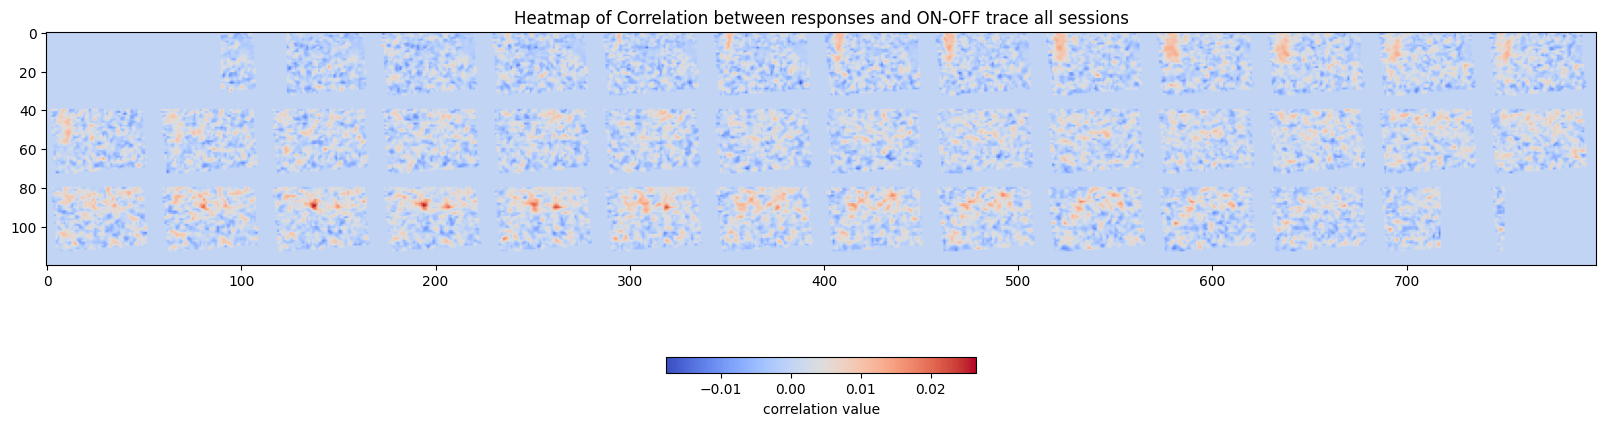

In [ ]:
plot_slices_heatmap(corr_slics, 'Heatmap of Correlation between responses and ON-OFF trace all sessions')

In [ ]:
for threshold in range(90,100):
    thresholded_corr_indices = np.where(corr_data_3d>np.percentile(corr_data_3d.flatten(), threshold, axis=0))
    np.save(output_path + '/response_onset_' + str(onset) + '/all'+f'/active_indices_percentile_{threshold}.npy', 
                thresholded_corr_indices)

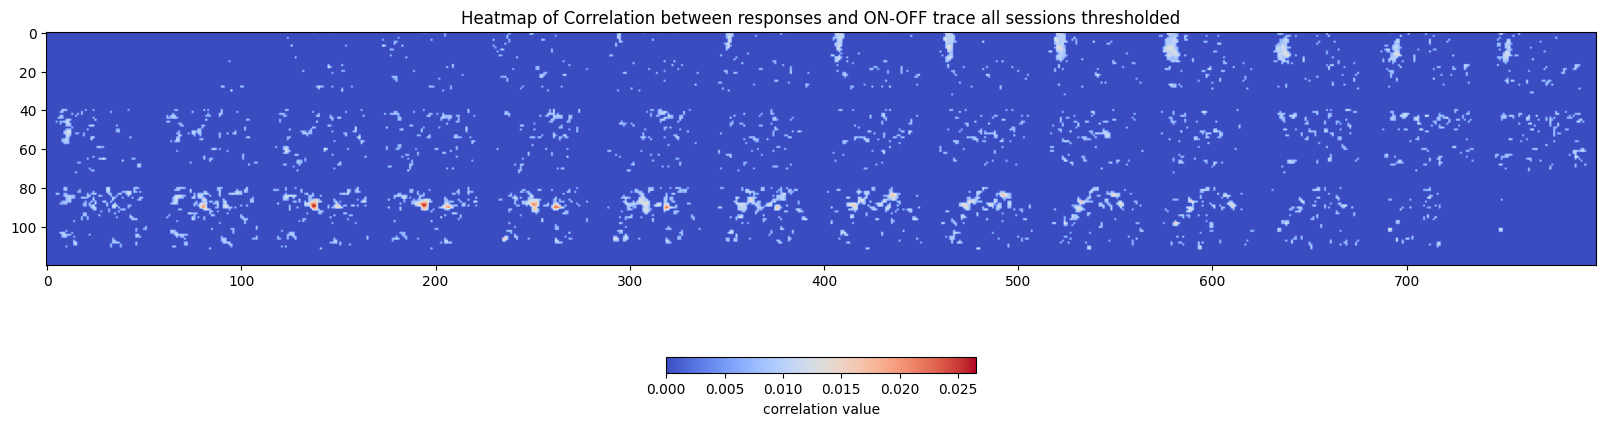

In [ ]:
thresholded_corr = np.where(corr_data_3d>np.percentile(corr_data_3d.flatten(), 97, axis=0),
                            corr_data_3d, 0)
thresholded_corr_slices = get_stacked_slices_plot(thresholded_corr)
plot_slices_heatmap(thresholded_corr_slices, 'Heatmap of Correlation between responses and ON-OFF trace all sessions thresholded')

In [43]:
np.save(output_path + '/response_onset_' + str(onset) + '/all'+f'/active_indices_percentile_{threshold}.npy', thresholded_corr_indices)

In [ ]:
fig, ax = plt.subplots()
ax.grid()

n, bins, patches = ax.hist(non_nan_correlations, bins=115)
ax.set_xlabel('Histogram of Correlation between responses and ON-OFF trace')
# ax.set_ylabel('Probability density')
# ax.set_title(f'Histogram of {data_model_name}')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.savefig('Histogram of Correlation between responses and ON-OFF trace'+'.png')
plt.show()

In [45]:
brain_map_shape = (40, 57, 66)
corr_data_3d = correlations.reshape(brain_map_shape).astype(float)
sample_data_3d = stim[:, np.random.randint(stim.shape[1])].reshape(brain_map_shape)

In [46]:
corr_data_3d.min(), corr_data_3d.max()

(-0.11882680355657546, 0.3451248745553329)

In [47]:
sample_actual_slices = get_stacked_slices(sample_data_3d)
kernel = np.ones((1,2),np.float32)
corr_slices = get_stacked_slices(corr_data_3d, False
                                 , kernel)

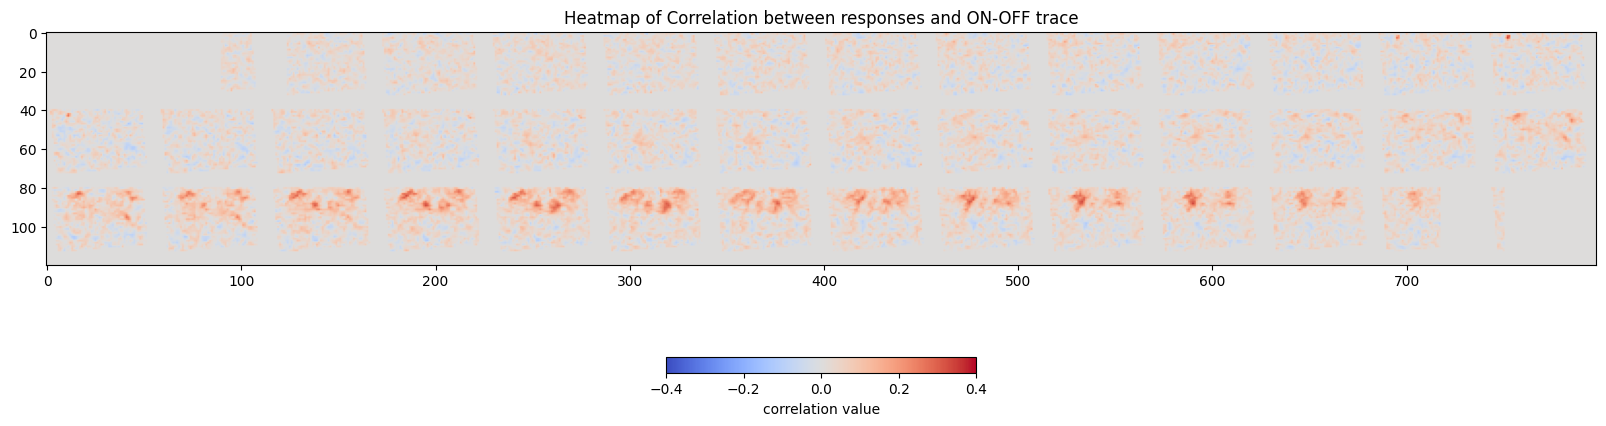

In [49]:
plot_slices_heatmap(corr_slices, 'Heatmap of Correlation between responses and ON-OFF trace')

In [50]:
threshold = 98
thresholded_corr = np.where(corr_data_3d>np.percentile(corr_data_3d.flatten(), threshold, axis=0),
                            corr_data_3d, 0)
thresholded_corr_slices = get_stacked_slices(thresholded_corr)

In [51]:
np.percentile(corr_data_3d.flatten(), threshold, axis=0)

0.09641066030436272

In [52]:
thresholded_corr = np.where(corr_data_3d>np.percentile(corr_data_3d.flatten(), threshold, axis=0),
                            corr_data_3d, 0)
thresholded_corr_slices = get_stacked_slices(thresholded_corr)

In [53]:
# thresholded_corr_slices

In [54]:
thresholds = [th for th in range(0,100)] 
percentiles = [np.percentile(corr_data_3d.flatten(), th, axis=0) for th in thresholds]

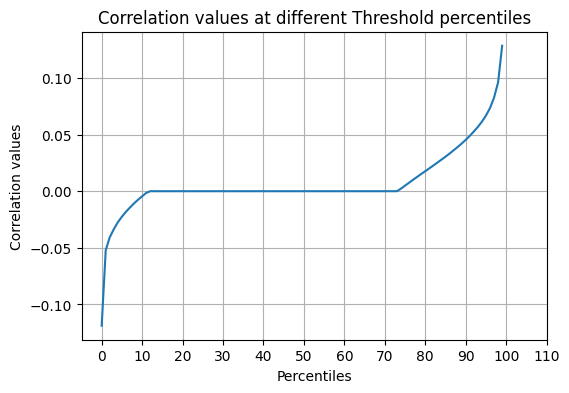

In [55]:
fig, ax = plt.subplots(figsize = [6,4])
ax.plot(thresholds, percentiles)
ax.grid(which='both')
plt.xticks(np.arange(0, 115, 10))
ax.set_xlabel("Percentiles")
ax.set_ylabel("Correlation values")
ax.set_title('Correlation values at different Threshold percentiles')
# # Save the image to a file (replace 'output_image.png' with your desired filename)
plt.savefig('Correlation values at different Threshold percentiles.png')
plt.show()

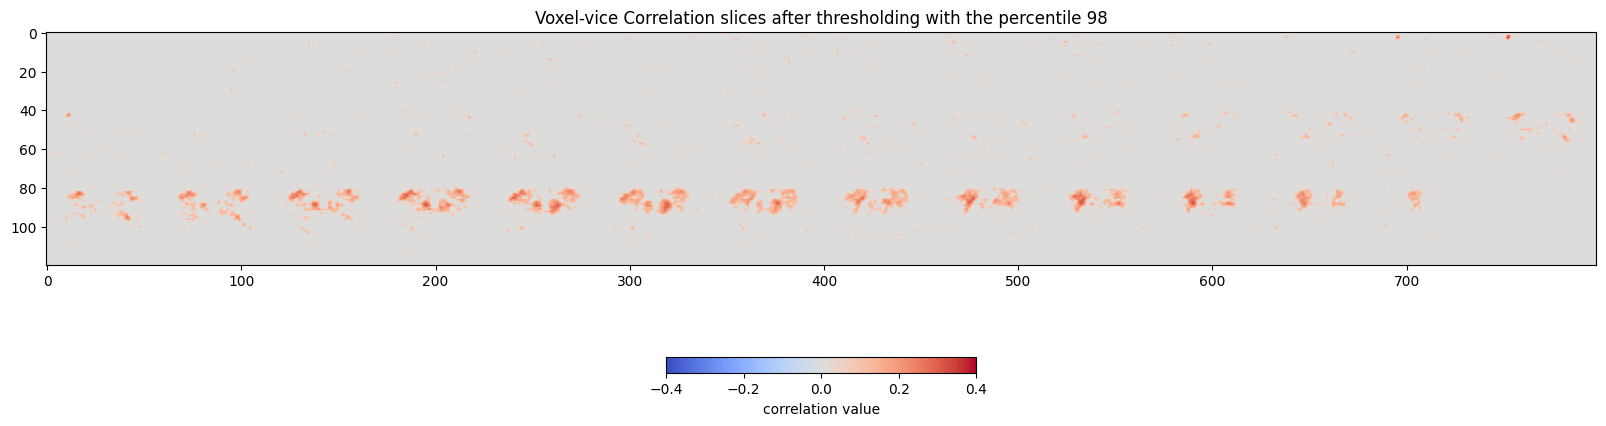

In [56]:
plot_slices_heatmap(thresholded_corr_slices, f'Voxel-vice Correlation slices after thresholding with the percentile {threshold}')

In [57]:
thresholded_corr_indices = np.where(corr_data_3d>np.percentile(corr_data_3d.flatten(), threshold, axis=0))

In [58]:
corr_data_3d[thresholded_corr_indices].shape

(3010,)

In [59]:
thresholded_corr_indices[0][30], thresholded_corr_indices[1][30], thresholded_corr_indices[2][30]

(1, 15, 43)

In [62]:
# Save the indices to a file
output_dir_name = 'anesthetic_state/response_4th_onset'
np.save(output_dir_name+f'/active_indices_percentile_{threshold}.npy', thresholded_corr_indices)